### Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch_geometric.data import Data
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import GCNConv
import torch.nn as nn
from itertools import product
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score
from copy import deepcopy

import sys
sys.path.append('../src')
from utils import TimeStepSplit

### Load Data

In [2]:
df_node = pd.read_csv('../data/processed/node_data.csv')
df_edge = pd.read_csv('../data/processed/edge_data.csv')

display(df_node, df_edge)

,txId,class,timeStep,localF0,localF1,localF2,localF3,localF4,localF5,localF6,...,aggregatedF61,aggregatedF62,aggregatedF63,aggregatedF64,aggregatedF65,aggregatedF66,aggregatedF67,aggregatedF68,aggregatedF69,aggregatedF70
0,0,2,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,1,2,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,2,2,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,3,0,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,4,2,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203764,203764,2,49,-0.145771,-0.163752,0.463609,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.577099,-0.613614,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
203765,203765,2,49,-0.165920,-0.123607,1.018602,-0.121970,-0.043875,-0.113002,-0.061584,...,0.162722,0.010822,1.461330,1.461369,-0.098889,-0.087490,-0.084674,-0.140597,-1.760926,-1.760984
203766,203766,1,49,-0.172014,-0.078182,1.018602,0.028105,-0.043875,0.054722,-0.061584,...,1.261246,1.985050,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
203767,203767,2,49,-0.172842,-0.176622,1.018602,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.397749,-0.411776,1.461330,1.461369,-0.098889,-0.087490,-0.084674,-0.140597,1.519700,1.521399


,txId1,txId2
0,0,1
1,2,3
2,4,5
3,6,7
4,8,9
...,...,...
234350,203602,201430
234351,203603,203099
234352,201921,202042
234353,201480,201368


### Train Test Split

In [3]:
# Train/test mask
train_mask = torch.tensor((df_node['timeStep'] <= 35) & (df_node['class'] != 2), dtype=torch.bool)
test_mask = torch.tensor((df_node['timeStep'] > 35) & (df_node['class'] != 2), dtype=torch.bool)

### Features & Edges

In [4]:
# node features
local_features = [col for col in df_node.columns if col.startswith('localF')]
aggregate_features = [col for col in df_node.columns if col.startswith('aggregatedF')]
all_features = local_features + aggregate_features

# edge_index
edge_index = torch.tensor(df_edge[['txId1', 'txId2']].values.T, dtype=torch.long)

### Model

In [5]:
class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, dropout=0.5, output_dim=2):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

In [43]:
def train(model, data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

In [14]:
def evaluate(model, data, mask):
    model.eval()
    with torch.no_grad():
        out = model(data)
        prob = F.softmax(out, dim=1)
        pred = out.argmax(dim=1)

        y_true = data.y[mask].cpu().numpy()
        y_pred = pred[mask].cpu().numpy()
        y_prob = prob[mask][:, 1].cpu().numpy()

        mask_binary = (y_true != 2)
        y_true = y_true[mask_binary]
        y_pred = y_pred[mask_binary]
        y_prob = y_prob[mask_binary]

        f1 = f1_score(y_true, y_pred, average='macro')
        precision = precision_score(y_true, y_pred, average='macro')
        recall = recall_score(y_true, y_pred, average='macro')
        roc_auc = roc_auc_score(y_true, y_prob,)

    return {
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'roc_auc': roc_auc
    }

In [17]:
param_grid = {
    'hidden_dim': [32, 64],
    'lr': [1e-2, 1e-3],
    'dropout': [0, 0.3],
}

param_combinations = list(product(*param_grid.values()))
param_names = list(param_grid.keys())

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

---

### 2-layer GCN (Local Features)

In [ ]:
x_loc = torch.tensor(df_node[local_features].values, dtype=torch.float)
y = torch.tensor(df_node['class'].values, dtype=torch.long)

# PyG data object
data = Data(x=x_loc, edge_index=edge_index, y=y, train_mask=train_mask, test_mask=test_mask)

display(data)

Data(x=[203769, 94], edge_index=[2, 234355], y=[203769], train_mask=[203769], test_mask=[203769])

- Hyperparameter Tuning

In [18]:
train_df = df_node[df_node['timeStep'] <= 35]
cv = TimeStepSplit(train_df, n_splits=4)

best_f1 = 0
best_params = None
best_metrics = None

for param_values in param_combinations:
    params = dict(zip(param_names, param_values))
    fold_scores = []
    print(f"\nRunning config: {params}")

    for fold_idx, (train_idx, val_idx) in enumerate(cv.split(train_df), start=1):
        print(f"Fold {fold_idx}/{cv.get_n_splits()}")
        data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
        data.val_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
        data.train_mask[train_idx] = True
        data.val_mask[val_idx] = True

        model = GCN(input_dim=data.x.shape[1], hidden_dim=params['hidden_dim'],
                    dropout=params['dropout'], output_dim=2).to(device)
        data = data.to(device)

        optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'], weight_decay=5e-4)

        class_weights = torch.tensor([0.3, 0.7]).to(device)
        criterion = nn.CrossEntropyLoss(weight=class_weights, ignore_index=2)

        for epoch in range(501):
            loss = train(model, data, optimizer, criterion)
            if epoch % 100 == 0:
                print(f"Epoch {epoch:03d} | Loss: {loss:.4f}")
                
        metrics = evaluate(model, data, data.val_mask)
        fold_scores.append(metrics)

    avg_metrics = {k: sum(d[k] for d in fold_scores) / len(fold_scores) for k in fold_scores[0]}

    if avg_metrics['f1'] > best_f1:
        best_f1 = avg_metrics['f1']
        best_params = deepcopy(params)
        best_metrics = deepcopy(avg_metrics)

print(f"\nBest Params: {best_params}")
print("Best Avg CV Metrics:")
for k, v in avg_metrics.items():
    print(f"{k}: {v:.4f}")


Running config: {'hidden_dim': 32, 'lr': 0.01, 'dropout': 0}
Fold 1/4
Epoch 000 | Loss: 0.1941
Epoch 100 | Loss: 0.0557
Epoch 200 | Loss: 0.0395
Epoch 300 | Loss: 0.0343
Epoch 400 | Loss: 0.0317
Epoch 500 | Loss: 0.0306
Fold 2/4
Epoch 000 | Loss: 0.3547
Epoch 100 | Loss: 0.1367
Epoch 200 | Loss: 0.1171
Epoch 300 | Loss: 0.1053
Epoch 400 | Loss: 0.0990
Epoch 500 | Loss: 0.0951
Fold 3/4
Epoch 000 | Loss: 1.4385
Epoch 100 | Loss: 0.2252
Epoch 200 | Loss: 0.2015
Epoch 300 | Loss: 0.1865
Epoch 400 | Loss: 0.1756
Epoch 500 | Loss: 0.1658
Fold 4/4
Epoch 000 | Loss: 3.6448
Epoch 100 | Loss: 0.2440
Epoch 200 | Loss: 0.2215
Epoch 300 | Loss: 0.2039
Epoch 400 | Loss: 0.1932
Epoch 500 | Loss: 0.1850

Running config: {'hidden_dim': 32, 'lr': 0.01, 'dropout': 0.3}
Fold 1/4
Epoch 000 | Loss: 0.6671
Epoch 100 | Loss: 0.1005
Epoch 200 | Loss: 0.0885
Epoch 300 | Loss: 0.0752
Epoch 400 | Loss: 0.0709
Epoch 500 | Loss: 0.0665
Fold 2/4
Epoch 000 | Loss: 1.7254
Epoch 100 | Loss: 0.1917
Epoch 200 | Loss: 0.

- Train

In [37]:
data = data.to(device)
best_model = GCN(
    input_dim=data.x.shape[1],
    hidden_dim=best_params['hidden_dim'],
    dropout=best_params['dropout'],
    output_dim=2
).to(device)

optimizer = torch.optim.Adam(best_model.parameters(), lr=best_params['lr'], weight_decay=5e-4)
criterion = nn.CrossEntropyLoss(weight=torch.tensor([0.3, 0.7]).to(device), ignore_index=2)

best_model.train()
for epoch in range(501):
    loss = train(best_model, data, optimizer, criterion)
    if epoch % 100 == 0:
        print(f"Epoch {epoch:03d} | Loss: {loss:.4f}")

test_metrics = evaluate(best_model, data, data.test_mask)

print("Best Avg CV Metrics:")
for k, v in test_metrics.items():
    print(f"{k}: {v:.4f}")

Epoch 000 | Loss: 1.9370
Epoch 100 | Loss: 0.2908
Epoch 200 | Loss: 0.2643
Epoch 300 | Loss: 0.2507
Epoch 400 | Loss: 0.2416
Epoch 500 | Loss: 0.2343
Best Avg CV Metrics:
f1: 0.6514
precision: 0.6206
recall: 0.7367
roc_auc: 0.8343


- Test

In [38]:
model.eval()
with torch.no_grad():
    logits = model(data)
    pred = logits.argmax(dim=1)
    prob = F.softmax(logits, dim=1)[:, 1]  # probability of class 1 (illicit)

# Only evaluate on known-class test nodes
y_true = data.y[data.test_mask].cpu().numpy()
y_pred = pred[data.test_mask].cpu().numpy()
y_prob = prob[data.test_mask].cpu().numpy()

print(classification_report(y_true, y_pred))
print(f"ROC AUC: {roc_auc_score(y_true, y_prob):6f}")

              precision    recall  f1-score   support

           0       0.98      0.89      0.93     14428
           1       0.27      0.64      0.38       901

    accuracy                           0.88     15329
   macro avg       0.62      0.77      0.66     15329
weighted avg       0.93      0.88      0.90     15329

ROC AUC: 0.859146


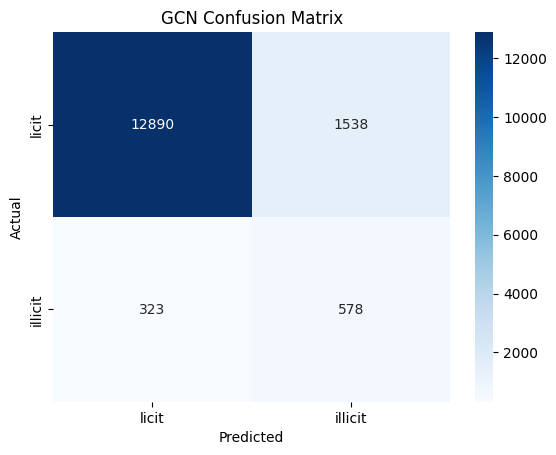

In [39]:
cm = confusion_matrix(y_true, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['licit', 'illicit'], 
            yticklabels=['licit', 'illicit'])
plt.title("GCN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

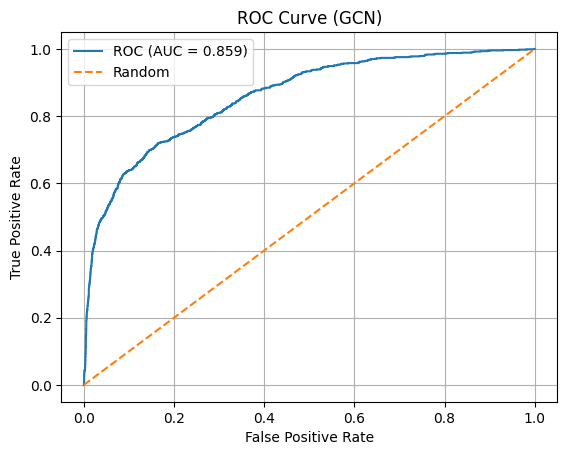

In [40]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], '--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (GCN)')
plt.legend()
plt.grid(True)
plt.show()

- Train

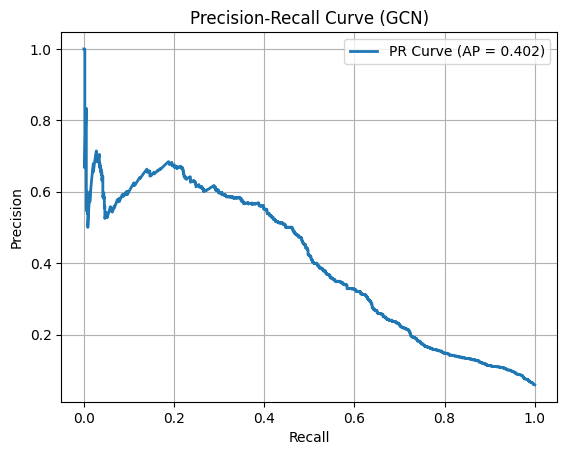

In [41]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true, y_prob)
ap = average_precision_score(y_true, y_prob)

plt.plot(recall, precision, lw=2, label=f'PR Curve (AP = {ap:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (GCN)')
plt.legend()
plt.grid(True)
plt.show()

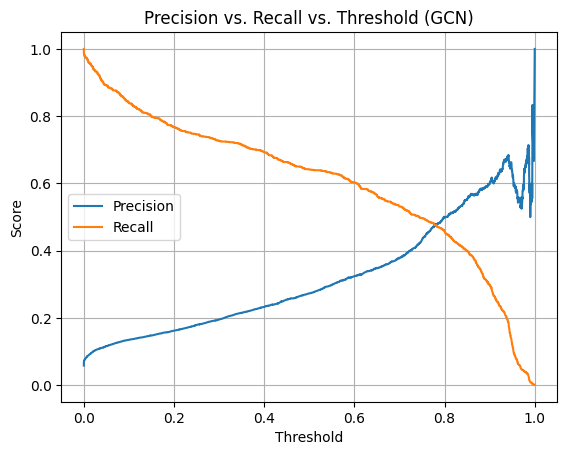

In [42]:
# Precision-Recall vs Threshold
precision, recall, thresholds = precision_recall_curve(y_true, y_prob)

plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision vs. Recall vs. Threshold (GCN)')
plt.legend()
plt.grid(True)
plt.show()